In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pyspark tensorflow keras

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



Summary:
|       |    Close |     Open |     High |      Low |            Vol |     Change % |
|:------|---------:|---------:|---------:|---------:|---------------:|-------------:|
| count |  4254    |  4254    |  4254    |  4254    | 4254           | 4254         |
| mean  | 13122.6  | 13139.9  | 13338.4  | 12935.2  |    7.62745e+06 |    0.0613916 |
| std   |  8550.31 |  8561.42 |  8719.83 |  8398.94 |    7.7199e+06  |    2.57173   |
| min   |  2858    |  2816.4  |  2913.5  |  2816.4  | 2720           |  -10         |
| 25%   |  7573.3  |  7516.62 |  7630.4  |  7408.4  |    2.3325e+06  |   -1.33      |
| 50%   | 10533.8  | 10544.2  | 10672    | 10440    |    4.725e+06   |    0         |
| 75%   | 14937.9  | 15020.8  | 15192.9  | 14723.9  |    1.018e+07   |    1.2975    |
| max   | 49668.9  | 50468.5  | 51268.2  | 48869.2  |    6.956e+07   |   13.29      |




C:\Users\FPT\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50], Loss: 1.1930184364318848
Epoch [20/50], Loss: 0.4271082580089569
Epoch [30/50], Loss: 0.14761856198310852
Epoch [40/50], Loss: 0.05167314037680626
Epoch [50/50], Loss: 0.025202495977282524
Mean Squared Error on Test Data: 0.1134534701704979


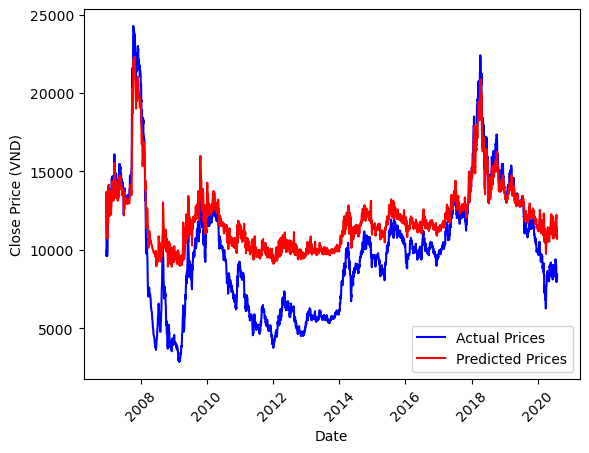

Predicted Close Price for the new day: 11598.08739198567


In [118]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Đọc dữ liệu từ CSV
df = pd.read_csv("SSIHistoricalData.csv")

# Tiền xử lý dữ liệu
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
selected_columns = ["Close", "Open", "High", "Low", "Vol", "Change %"]

# Chuyển đổi kiểu dữ liệu và chuẩn hóa
df["Vol"] = df["Vol"].replace({',': ''}, regex=True).replace({'M': '*1e6', 'K': '*1e3'}, regex=True).map(pd.eval).astype(float)

# Xử lý cột "Change %"
df["Change %"] = df["Change %"].str.replace('%', '').astype(float)

# Xử lý các cột số có dấu phẩy
numeric_columns = ["Close", "Open", "High", "Low", "Vol"]
df[numeric_columns] = df[numeric_columns].replace({',': ''}, regex=True).astype(float)

# Tóm tắt thống kê của DataFrame
summary = df.describe()
# Thay đổi cách hiển thị summary
print("\nSummary:")
print(summary.to_markdown())
print("\n")

# Đổi chiều rộng của cửa sổ console để tránh việc rớt dòng
pd.set_option('display.width', 1000)
# Chuẩn hóa giá trị
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[selected_columns])

# Chuẩn bị dữ liệu cho mô hình LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length-1:i+seq_length, 0]  # Dự đoán giá trị "Price"
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 30  # Độ dài của mỗi chuỗi
X, y = create_sequences(scaled_data, seq_length)

# Chia thành tập huấn luyện và tập kiểm thử
test_size = int(len(X) * 0.2)
X_train, X_test, y_train, y_test = X[:test_size], X[test_size:], y[:test_size], y[test_size:]

# Chuyển đổi thành PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Định nghĩa mô hình LSTM để dự đoán giá trị "Price"
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Tạo và huấn luyện mô hình LSTM mới
input_size = X_train_tensor.shape[2]
output_size = 1  # Dự đoán chỉ cột "Price"
hidden_size = 100
dropout_rate = 0.2

model = LSTMModel(input_size, hidden_size, output_size, dropout_rate)
torch.save(model.state_dict(), "./savemodel/model.pth")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Dự đoán trên tập kiểm thử
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    mse = mean_squared_error(y_test_tensor[:, 0], test_outputs[:, 0])
    print(f'Mean Squared Error on Test Data: {mse}')

# Tính toán giá trị trung bình và độ lệch chuẩn của dữ liệu gốc
original_means = df[selected_columns].mean().values
original_stds = df[selected_columns].std().values

# Chuẩn hóa ngược lại giá trị của y_test
y_test_original = (y_test[:, 0] * original_stds[0]) + original_means[0]

# Chuẩn hóa ngược lại giá trị của test_outputs
test_outputs_original = (test_outputs[:, 0] * original_stds[0]) + original_means[0]

# Hiển thị trên đồ thị
plt.plot(df.index[-len(y_test):], y_test_original, label='Actual Prices', color='blue')
plt.plot(df.index[-len(y_test):], test_outputs_original, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.xticks(rotation=45)
plt.legend()
plt.show()


def preprocess_data(data):
    # Chuyển đổi kiểu dữ liệu và chuẩn hóa
    if 'M' in data[5]:
        vol = float(str(data[5]).replace(',', '').replace('M', '')) * 1e6
        data[5] = vol
    elif 'K' in data[5]:
        vol = float(str(data[5]).replace(',', '').replace('K', '')) * 1e3
        data[5] = vol
    change_percent = float(str(data[6]).replace('%', ''))
    # Xử lý các cột số có dấu phẩy
    numeric_columns = [1, 2, 3, 4]
    for col in numeric_columns:
        data[col] = float(str(data[col]).replace(',', ''))

    processed_data = np.array(data[1:-1])  # Loại bỏ cột ngày và % thay đổi
    return processed_data


def preprocess_new_data(new_data):
    # Xử lý dữ liệu mới cho ngày hiện tại
    processed_data = preprocess_data(new_data)  # Sử dụng hàm preprocess_data để chuyển đổi dữ liệu

    # Tạo chuỗi dữ liệu cho ngày hiện tại
    sequence = processed_data[-seq_length:]  # Lấy seq_length ngày gần đây nhất

    # Chuyển đổi thành PyTorch tensor và mở rộng chiều batch_size
    new_data_tensor = torch.tensor([sequence], dtype=torch.float32).unsqueeze(0)

    return new_data_tensor


# Chuẩn bị dữ liệu mới của ngày hiện tại
new_data = preprocess_new_data(["01/25/2024", "33,950.0", "34,050.0", "34,200.0", "33,850.0", "10.94M", "-0.15%"])

# Dự đoán giá Close cho ngày mới
with torch.no_grad():
    model.eval()
    predicted_close = model(new_data)
    model.train()

# Lấy giá trị trung bình và độ lệch chuẩn từ dữ liệu gốc
original_mean = scaler.mean_[0]
original_std = scaler.scale_[0]

# Ngược lại quá trình chuẩn hóa
predicted_close_original = (predicted_close.item() * original_std) + original_mean

print("Predicted Close Price for the new day:", predicted_close_original)



In [77]:
 pip install kafka-python

Note: you may need to restart the kernel to use updated packages.



Summary:
|       |    Close |     Open |     High |      Low |            Vol |     Change % |
|:------|---------:|---------:|---------:|---------:|---------------:|-------------:|
| count |  4254    |  4254    |  4254    |  4254    | 4254           | 4254         |
| mean  | 13122.6  | 13139.9  | 13338.4  | 12935.2  |    7.62745e+06 |    0.0613916 |
| std   |  8550.31 |  8561.42 |  8719.83 |  8398.94 |    7.7199e+06  |    2.57173   |
| min   |  2858    |  2816.4  |  2913.5  |  2816.4  | 2720           |  -10         |
| 25%   |  7573.3  |  7516.62 |  7630.4  |  7408.4  |    2.3325e+06  |   -1.33      |
| 50%   | 10533.8  | 10544.2  | 10672    | 10440    |    4.725e+06   |    0         |
| 75%   | 14937.9  | 15020.8  | 15192.9  | 14723.9  |    1.018e+07   |    1.2975    |
| max   | 49668.9  | 50468.5  | 51268.2  | 48869.2  |    6.956e+07   |   13.29      |




C:\Users\FPT\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [10/50], Loss: 1.6584501266479492
Epoch [20/50], Loss: 0.5467896461486816
Epoch [30/50], Loss: 0.15819354355335236
Epoch [40/50], Loss: 0.037805985659360886
Epoch [50/50], Loss: 0.028540674597024918
Mean Squared Error on Test Data: 0.12252423167228699


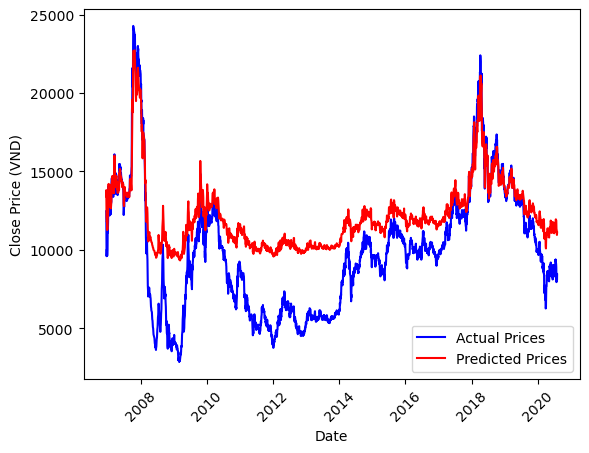

Received:  ['01/25/2024', '33,950.0', '34,050.0', '34,200.0', '33,850.0', '10.94M', '-0.15']
Predicted Close Price for the new day: 13515.64894728572
Received:  ['01/25/2024', '34,950.0', '34,050.0', '34,200.0', '33,850.0', '10.94M', '-0.15']
Predicted Close Price for the new day: 13515.64894728572
Received:  ['01/25/2024', '34,950.0', '36,050.0', '34,200.0', '33,850.0', '10.94M', '-0.15']
Predicted Close Price for the new day: 13515.64894728572
Received:  ['01/26/2024', '32,950.0', '36,050.0', '34,200.0', '33,850.0', '10.94M', '-0.15']
Predicted Close Price for the new day: 13515.64894728572
Received:  ['01/26/2024', '32,950.0', '36,050.0', '34,200.0', '33,850.0', '10.94M', '-0.15']
Predicted Close Price for the new day: 13515.64894728572
Received:  ['01/26/2024', '32,950.0', '36,050.0', '34,200.0', '33,850.0', '10.94M', '-0.15']
Predicted Close Price for the new day: 13515.64894728572
Received:  ['01/26/2024', '32,950.0', '36,050.0', '34,200.0', '33,850.0', '10.94M', '-0.15']
Predict

KeyboardInterrupt: 

In [133]:
from kafka import KafkaConsumer
import json
import pandas as pd
import numpy as np
import torch
from torch.nn import Module
from torch.nn import LSTM, Linear, BatchNorm1d, Dropout
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

# Khởi tạo Spark Session
spark = SparkSession.builder \
    .appName("StockPricePrediction") \
    .getOrCreate()

# Định nghĩa schema cho dữ liệu streaming
schema = StructType([
    StructField("Date", StringType(), True),
    StructField("Open", DoubleType(), True),
    StructField("High", DoubleType(), True),
    StructField("Low", DoubleType(), True),
    StructField("Close", DoubleType(), True),
    StructField("Vol", DoubleType(), True),
    StructField("Change%", DoubleType(), True)
])

# Kafka bootstrap servers
kafka_bootstrap_servers = 'localhost:9092'

# Tạo consumer
consumer = KafkaConsumer('stockprediction',
                         group_id='new_consumer_group',
                         bootstrap_servers=kafka_bootstrap_servers,
                         value_deserializer=lambda x: json.loads(x.decode('utf-8')),
                         auto_offset_reset='latest')

# Đọc dữ liệu từ CSV
df = pd.read_csv("SSIHistoricalData.csv")

# Tiền xử lý dữ liệu
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
selected_columns = ["Close", "Open", "High", "Low", "Vol", "Change %"]

# Chuyển đổi kiểu dữ liệu và chuẩn hóa
df["Vol"] = df["Vol"].replace({',': ''}, regex=True).replace({'M': '*1e6', 'K': '*1e3'}, regex=True).map(pd.eval).astype(float)

# Xử lý cột "Change %"
df["Change %"] = df["Change %"].str.replace('%', '').astype(float)

# Xử lý các cột số có dấu phẩy
numeric_columns = ["Close", "Open", "High", "Low", "Vol"]
df[numeric_columns] = df[numeric_columns].replace({',': ''}, regex=True).astype(float)

# Tóm tắt thống kê của DataFrame
summary = df.describe()
# Thay đổi cách hiển thị summary
print("\nSummary:")
print(summary.to_markdown())
print("\n")

# Đổi chiều rộng của cửa sổ console để tránh việc rớt dòng
pd.set_option('display.width', 1000)
# Chuẩn hóa giá trị
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[selected_columns])

# Chuẩn bị dữ liệu cho mô hình LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length-1:i+seq_length, 0]  # Dự đoán giá trị "Price"
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 30  # Độ dài của mỗi chuỗi
X, y = create_sequences(scaled_data, seq_length)

# Chia thành tập huấn luyện và tập kiểm thử
test_size = int(len(X) * 0.2)
X_train, X_test, y_train, y_test = X[:test_size], X[test_size:], y[:test_size], y[test_size:]

# Chuyển đổi thành PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Định nghĩa mô hình LSTM để dự đoán giá trị "Price"
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Tạo và huấn luyện mô hình LSTM mới
input_size = X_train_tensor.shape[2]
output_size = 1  # Dự đoán chỉ cột "Price"
hidden_size = 100
dropout_rate = 0.2

model = LSTMModel(input_size, hidden_size, output_size, dropout_rate)
torch.save(model.state_dict(), "./savemodel/model.pth")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Dự đoán trên tập kiểm thử
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    mse = mean_squared_error(y_test_tensor[:, 0], test_outputs[:, 0])
    print(f'Mean Squared Error on Test Data: {mse}')

# Tính toán giá trị trung bình và độ lệch chuẩn của dữ liệu gốc
original_means = df[selected_columns].mean().values
original_stds = df[selected_columns].std().values

# Chuẩn hóa ngược lại giá trị của y_test
y_test_original = (y_test[:, 0] * original_stds[0]) + original_means[0]

# Chuẩn hóa ngược lại giá trị của test_outputs
test_outputs_original = (test_outputs[:, 0] * original_stds[0]) + original_means[0]

# Hiển thị trên đồ thị
plt.plot(df.index[-len(y_test):], y_test_original, label='Actual Prices', color='blue')
plt.plot(df.index[-len(y_test):], test_outputs_original, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.xticks(rotation=45)
plt.legend()
plt.show()


def preprocess_data(data):
    # Chuyển đổi kiểu dữ liệu và chuẩn hóa
    if 'M' in data[5]:
        vol = float(str(data[5]).replace(',', '').replace('M', '')) * 1e6
        data[5] = vol
    elif 'K' in data[5]:
        vol = float(str(data[5]).replace(',', '').replace('K', '')) * 1e3
        data[5] = vol
    change_percent = float(str(data[6]).replace('%', ''))
    # Xử lý các cột số có dấu phẩy
    numeric_columns = [1, 2, 3, 4]
    for col in numeric_columns:
        data[col] = float(str(data[col]).replace(',', ''))

    processed_data = np.array(data[1:-1])  # Loại bỏ cột ngày và % thay đổi
    return processed_data

def preprocess_new_data(new_data):
    # Xử lý dữ liệu mới cho ngày hiện tại
    processed_data = preprocess_data(new_data)  # Sử dụng hàm preprocess_data để chuyển đổi dữ liệu

    # Tạo chuỗi dữ liệu cho ngày hiện tại
    sequence = processed_data[-seq_length:]  # Lấy seq_length ngày gần đây nhất

    # Chuyển đổi thành PyTorch tensor và mở rộng chiều batch_size
    new_data_tensor = torch.tensor([sequence], dtype=torch.float32).unsqueeze(0)

    return new_data_tensor


# Lặp để lấy dữ liệu từ Kafka topic
for message in consumer:
    newdata = message.value
    print("Received: ",newdata)

    # Chuẩn bị dữ liệu mới của ngày hiện tại
    latest_data = preprocess_new_data(newdata)

    # Dự đoán giá Close cho ngày mới
    with torch.no_grad():
        model.eval()
        predicted_close = model(latest_data)
        model.train()

    # Lấy giá trị trung bình và độ lệch chuẩn từ dữ liệu gốc
    original_mean = scaler.mean_[0]
    original_std = scaler.scale_[0]

    # Ngược lại quá trình chuẩn hóa
    predicted_close_original = (predicted_close.item() * original_std) + original_mean

    print("Predicted Close Price for the new day:", predicted_close_original)


# Đóng consumer
consumer.close()